# LLM Decoding from Scratch

This notebook demonstrates how to implement text generation decoding strategies from scratch using a real language model (GPT-2 small).

## What We'll Build

| Strategy | Description | Use Case |
|----------|-------------|----------|
| **Greedy** | Always pick highest probability token | Deterministic, fast |
| **Temperature** | Scale logits before softmax | Control randomness |
| **Top-p (Nucleus)** | Sample from smallest set with cumulative p | Dynamic vocabulary |
| **Beam Search** | Track multiple candidates | Higher quality |

---

## Key Insight: LLMs Only Predict Next Token

```
Input: "The cat sat on the"
                          ↓
              [LLM computes logits]
                          ↓
         logits = [2.1, -0.5, 3.2, ...] (vocab_size)
                          ↓
              [Apply decoding strategy]
                          ↓
                  Next token: "mat"
```

The **decoding strategy** is how we convert logits → next token.

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.46.0
!pip list

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.8 MB/s eta 0:00:00
Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.2
    Uninstalling tokenizers-0.22.2:
      Successfully uninstalled tokenizers-0.22.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
Package                                  Version
---------------------------------------- ------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                  

---
## Setup: Load GPT-2 Small

In [3]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Load GPT-2 small (124M parameters - smallest real LLM)
print("Loading GPT-2 small...")
model_name = "gpt2"  # gpt2 = gpt2-small (124M params)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on: {device}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading GPT-2 small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on: cpu
Vocabulary size: 50257
Model parameters: 124,439,808


---
## Understanding Logits

The model outputs **logits** - raw scores for each token in the vocabulary.

```
logits[i] = how much the model "likes" token i as the next token
```

In [4]:
def get_next_token_logits(prompt: str) -> torch.Tensor:
    """
    Get logits for the next token given a prompt.

    Returns: tensor of shape (vocab_size,)
    """
    # Tokenize input
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Forward pass (no gradient needed for inference)
    with torch.no_grad():
        outputs = model(input_ids)
        # outputs.logits shape: (batch=1, seq_len, vocab_size)
        # We want the logits for the LAST position (next token prediction)
        logits = outputs.logits[0, -1, :]  # shape: (vocab_size,)

    return logits

# Demo: Get logits for a prompt
prompt = "The capital of France is"
logits = get_next_token_logits(prompt)

print(f"Prompt: '{prompt}'")
print(f"Logits shape: {logits.shape}")
print(f"Logits range: [{logits.min():.2f}, {logits.max():.2f}]")

# Show top 10 tokens by logit value
top_k_logits, top_k_indices = torch.topk(logits, 10)
print("\nTop 10 tokens by logit:")
for i, (logit, idx) in enumerate(zip(top_k_logits, top_k_indices)):
    token = tokenizer.decode([idx])
    print(f"  {i+1}. '{token}' (logit: {logit:.2f})")

Prompt: 'The capital of France is'
Logits shape: torch.Size([50257])
Logits range: [-129.87, -100.25]

Top 10 tokens by logit:
  1. ' the' (logit: -100.25)
  2. ' now' (logit: -100.82)
  3. ' a' (logit: -100.86)
  4. ' France' (logit: -101.21)
  5. ' Paris' (logit: -101.21)
  6. ' in' (logit: -101.41)
  7. ' also' (logit: -101.41)
  8. ' not' (logit: -101.52)
  9. ' home' (logit: -101.54)
  10. ' still' (logit: -101.95)


---
## Strategy 1: Greedy Decoding

**Simplest strategy**: Always pick the token with the highest logit.

```python
next_token = argmax(logits)
```

**Pros**: Deterministic, fast  
**Cons**: Repetitive, boring text

In [5]:
def greedy_decode(prompt: str, max_new_tokens: int = 50) -> str:
    """
    Greedy decoding: always pick the highest probability token.

    Algorithm:
    1. Get logits for next token
    2. Pick token with highest logit (argmax)
    3. Append to sequence
    4. Repeat
    """
    # Start with the prompt tokens
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids[0].tolist()  # Convert to list for easier manipulation

    for _ in range(max_new_tokens):
        # Create input tensor from current sequence
        input_tensor = torch.tensor([generated_ids]).to(device)

        # Get logits for next token
        with torch.no_grad():
            outputs = model(input_tensor)
            logits = outputs.logits[0, -1, :]  # (vocab_size,)


        # GREEDY: Pick the token with highest logit
        next_token_id = torch.argmax(logits).item()
          ##This line collapses the entire probability distribution to a single choice
          ##No uncertainty, no exploration, no recovery from bad early decisions
          ##Errors and repetitions compound over time

        # Append to sequence
        generated_ids.append(next_token_id)

        # Stop if we hit end of text token
        if next_token_id == tokenizer.eos_token_id:
            break

    # Decode back to text
    return tokenizer.decode(generated_ids)

# Test greedy decoding
prompt = "The meaning of life is"
print(f"Prompt: '{prompt}'")
print("\n" + "="*50)
print("GREEDY OUTPUT:")
print("="*50)
output = greedy_decode(prompt, max_new_tokens=30)
print(output)

print("\n" + "-"*50)
#print("Once upon a time, the world was a place of great beauty and great danger. \nThe world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger")
print("Note: Greedy is deterministic - same input always gives same output")
print("Run it again - you'll get the exact same text!")

Prompt: 'The meaning of life is'

GREEDY OUTPUT:
The meaning of life is not the same as the meaning of death.

The meaning of life is not the same as the meaning of death.

The meaning of

--------------------------------------------------
Note: Greedy is deterministic - same input always gives same output
Run it again - you'll get the exact same text!


In [6]:
def greedy_decode_debug(prompt: str, max_new_tokens: int = 50) -> str:
    model.eval()

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids[0].tolist()

    print(f"\nInitial prompt: {repr(prompt)}")
    print("=" * 60)

    for step in range(max_new_tokens):
        input_tensor = torch.tensor([generated_ids]).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            logits = outputs.logits[0, -1, :]

        # Show top-5 candidates
        topk_logits, topk_ids = torch.topk(logits, 5)

        print(f"\nStep {step + 1}")
        print("-" * 40)
        print("Current text:")
        print(tokenizer.decode(generated_ids))

        print("\nTop-5 next-token candidates (logits):")
        for logit, tid in zip(topk_logits, topk_ids):
            print(f"  Token: {repr(tokenizer.decode([tid])):<12} | Logit: {logit.item():.2f}")

        # Greedy choice
        next_token_id = torch.argmax(logits).item()
        next_token = tokenizer.decode([next_token_id])

        print(f"\nGreedy choice → {repr(next_token)} (highest logit)")

        generated_ids.append(next_token_id)

        if next_token_id == tokenizer.eos_token_id:
            print("\n[EOS token encountered — stopping]")
            break

    print("\n" + "=" * 60)
    print("Final generated text:")
    print(tokenizer.decode(generated_ids))
    return tokenizer.decode(generated_ids)

prompt = "Life is"
output = greedy_decode_debug(prompt, max_new_tokens=50)
print(output)


Initial prompt: 'Life is'

Step 1
----------------------------------------
Current text:
Life is

Top-5 next-token candidates (logits):
  Token: ' a'         | Logit: -105.36
  Token: ' the'       | Logit: -105.69
  Token: ' not'       | Logit: -106.46
  Token: ' an'        | Logit: -106.98
  Token: ' about'     | Logit: -107.15

Greedy choice → ' a' (highest logit)

Step 2
----------------------------------------
Current text:
Life is a

Top-5 next-token candidates (logits):
  Token: ' great'     | Logit: -99.45
  Token: ' very'      | Logit: -99.84
  Token: ' game'      | Logit: -99.99
  Token: ' good'      | Logit: -100.50
  Token: ' big'       | Logit: -100.55

Greedy choice → ' great' (highest logit)

Step 3
----------------------------------------
Current text:
Life is a great

Top-5 next-token candidates (logits):
  Token: ' way'       | Logit: -99.85
  Token: ' thing'     | Logit: -100.81
  Token: ' time'      | Logit: -101.27
  Token: ' opportunity' | Logit: -101.70
  Token: 

---
## Strategy 2: Temperature Sampling

**Idea**: Scale logits before converting to probabilities.

```python
probs = softmax(logits / temperature)
next_token = sample from probs
```

| Temperature | Effect |
|-------------|--------|
| T < 1 | Sharper distribution (more deterministic) |
| T = 1 | Original distribution |
| T > 1 | Flatter distribution (more random) |
| T → 0 | Approaches greedy |
| T → ∞ | Uniform random |

In [7]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt

# Re-initialize tokenizer, model, and device to ensure they are defined
# This is done to prevent NameError if the setup cell was not run or its state was lost
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def temperature_decode(prompt: str, temperature: float = 1.0, max_new_tokens: int = 50, return_entropy: bool = False) -> str:
    """
    Temperature sampling: scale logits before softmax.

    Algorithm:
    1. Get logits for next token
    2. Divide logits by temperature
    3. Apply softmax to get probabilities
    4. Sample from the distribution
    5. Repeat
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids[0].tolist()
    entropy_value = None

    for step in range(max_new_tokens):
        input_tensor = torch.tensor([generated_ids]).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            logits = outputs.logits[0, -1, :]

        # TEMPERATURE: Scale logits
        scaled_logits = logits / temperature

        # Convert to probabilities
        probs = F.softmax(scaled_logits, dim=-1)

        # Sample from the distribution
        next_token_id = torch.multinomial(probs, num_samples=1).item()

        generated_ids.append(next_token_id)

        # we intrdouce entropy to mathematically visuazalise the curve
        if step == 0 and return_entropy:
            entropy_value = -(probs * torch.log(probs + 1e-9)).sum().item()

        if next_token_id == tokenizer.eos_token_id:
            break


    if return_entropy:
        return tokenizer.decode(generated_ids), entropy_value
    else:
        return tokenizer.decode(generated_ids)



# Compare different temperatures
prompt = "The meaning of life is"
print(f"Prompt: '{prompt}'\n")

entropies = []
# Define the temperatures list here
temperatures = []

for temp in [0.3, 0.4, 0.9, 1.0, 1.5, 1.8]:
    print(f"\n{'='*50}")
    print(f"TEMPERATURE = {temp}")
    print(f"{'='*50}")
    output, entropy = temperature_decode(prompt, temperature=temp, max_new_tokens=80, return_entropy=True)
    entropies.append(entropy)
    temperatures.append(temp) # Append temp to the temperatures list
    #print(output)
    print(textwrap.fill(output, width=70))
    print(f"Entropy: {entropy:.2f}")




Prompt: 'The meaning of life is'


TEMPERATURE = 0.3
The meaning of life is to be a living being, not a living thing. The
meaning of life is to be a living being, not a living thing.  The
meaning of life is to be a living being, not a living thing.  The
meaning of life is to be a living being, not a living thing.  The
meaning of life is to be a living being, not a living thing
Entropy: 1.04

TEMPERATURE = 0.4
The meaning of life is not a question of the existence of a god but of
the existence of a human being.  The question is not whether we should
live, but whether we should live by the law of nature.  The question
is not whether we should be human or not; it is whether we should live
by the law of nature.  The question is not whether we should be human
or not;
Entropy: 1.39

TEMPERATURE = 0.9
The meaning of life is to live for the sake of the benefit of all as
much as possible. The oath is an oath and an oath is a pledge of
loyalty as much as possible.  Aye, and owing to its subject 

Original logits: [4. 2. 1.]

Temperature = 0.3
Scaled logits: [13.333  6.667  3.333]
Probabilities: [0.9987 0.0013 0.    ]
Entropy: 0.0102

Temperature = 0.7
Scaled logits: [5.714 2.857 1.429]
Probabilities: [0.9335 0.0536 0.0128]
Entropy: 0.277

Temperature = 1.0
Scaled logits: [4. 2. 1.]
Probabilities: [0.8438 0.1142 0.042 ]
Entropy: 0.5243

Temperature = 1.5
Scaled logits: [2.667 1.333 0.667]
Probabilities: [0.7148 0.1884 0.0967]
Entropy: 0.7804

Temperature = 2
Scaled logits: [2.  1.  0.5]
Probabilities: [0.6285 0.2312 0.1402]
Entropy: 0.906


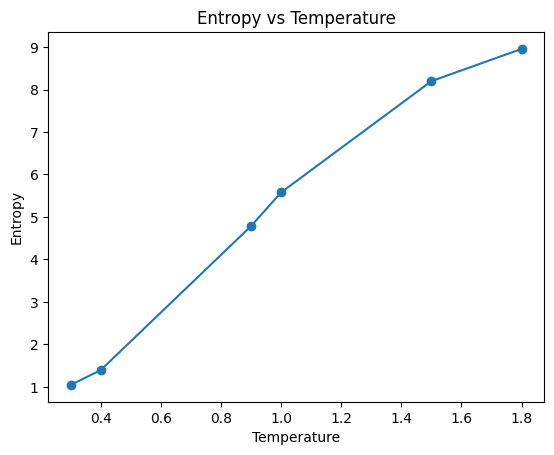

In [8]:
import numpy as np

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # stability
    return exp_x / exp_x.sum()

# Example logits (pretend model output)
#logits = np.array([1.0, 1.0, 1.0])
logits = np.array([4.0, 2.0, 1.0])
#logits = np.array([100.0, 1.0, 1.0])



#temperatures = [0.3, 0.4, 0.9, 1.0, 1.5, 1.8]

print("Original logits:", logits)

for T in [0.3, 0.7, 1.0, 1.5, 2]: # This loop is for showing softmax behavior, not tied to the global entropies list
    scaled_logits = logits / T
    #Dividing logits by temperature affects the exponent inside softmax,

    probs = softmax(scaled_logits)
    #causing small linear changes to produce large nonlinear effects on probabilities.

    entropy = -np.sum(probs * np.log(probs + 1e-9))

    print(f"\nTemperature = {T}")
    print("Scaled logits:", np.round(scaled_logits, 3))
    print("Probabilities:", np.round(probs, 4))
    print("Entropy:", round(entropy, 4))

# Use the 'temperatures' list that matches the 'entropies' list generated in the previous cell
plt.plot(temperatures, entropies, marker='o')
plt.xlabel("Temperature")
plt.ylabel("Entropy")
plt.title("Entropy vs Temperature")
plt.show()

---
## Strategy 3: Top-p (Nucleus) Sampling

**Idea**: Sample from the smallest set of tokens whose cumulative probability ≥ p.

```python
sorted_probs = sort probabilities descending
cumulative = cumsum(sorted_probs)
cutoff = first index where cumulative >= p
keep tokens up to cutoff
```

**Why better than top-k?** The number of tokens varies based on the distribution:
- Confident prediction → few tokens
- Uncertain prediction → more tokens

In [9]:
def top_p_decode(prompt: str, p: float = 0.9, temperature: float = 1.0, max_new_tokens: int = 50) -> str:
    """
    Top-p (nucleus) sampling: sample from smallest set with cumulative prob >= p.

    Algorithm:
    1. Get logits and convert to probabilities
    2. Sort probabilities in descending order
    3. Compute cumulative sum
    4. Find cutoff where cumsum >= p
    5. Keep only tokens up to cutoff
    6. Renormalize and sample
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids[0].tolist()

    for step in range(max_new_tokens):
        input_tensor = torch.tensor([generated_ids]).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            logits = outputs.logits[0, -1, :]

        # Apply temperature first
        scaled_logits = logits / temperature

        # Convert to probabilities
        probs = F.softmax(scaled_logits, dim=-1)

        # TOP-P: Sort probabilities descending
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)

        # top-p with their probabilites print
        topk_probs, topk_indices = torch.topk(probs, 3)
        print(f"\nStep {step+1} - BEFORE top-p")
        for i, idx in enumerate(topk_indices):
            token = tokenizer.decode([idx])
            print(f"  {i+1:02d}: '{token:>5}' | prob={topk_probs[i]:.4f}")

        # Compute cumulative sum
        cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

        # Find cutoff: where cumsum first exceeds p
        # We want to KEEP tokens where cumsum <= p (plus the first one that exceeds)
        sorted_indices_to_remove = cumsum_probs > p

        # Shift right to keep the first token that exceeds p
        sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
        sorted_indices_to_remove[0] = False

        # Set removed tokens to 0 probability
        sorted_probs[sorted_indices_to_remove] = 0

        # Will have a look at removed token
        removed_tokens = [tokenizer.decode([sorted_indices[i]])
                      for i, remove in enumerate(sorted_indices_to_remove) if remove]
        print(f"Tokens removed by top-p (p={p}): {removed_tokens[:10]}{'...' if len(removed_tokens)>10 else ''}")


        # Renormalize
        sorted_probs = sorted_probs / sorted_probs.sum()

        # Create full probability tensor
        filtered_probs = torch.zeros_like(probs)
        filtered_probs[sorted_indices] = sorted_probs

        # Sample
        next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()

        generated_ids.append(next_token_id)

        if next_token_id == tokenizer.eos_token_id:
            break

    return tokenizer.decode(generated_ids)

# Compare different p values
prompt = "The secret to happiness is"
print(f"Prompt: '{prompt}'\n")

for p_val in [0.5, 0.8, 0.95, 0.99]:
    print(f"\n{'='*50}")
    print(f"TOP-P = {p_val}")
    print(f"{'='*50}")
    output = top_p_decode(prompt, p=p_val, temperature=0.8, max_new_tokens=4)
    #print(output)
    print(textwrap.fill(output, width=70))

Prompt: 'The secret to happiness is'


TOP-P = 0.5

Step 1 - BEFORE top-p
  01: '   to' | prob=0.3380
  02: '  not' | prob=0.1978
  03: ' that' | prob=0.0724
Tokens removed by top-p (p=0.5): [' that', ' the', ' a', ' in', ' finding', ' knowing', ' love', ' being', ' self', ' understanding']...

Step 2 - BEFORE top-p
  01: '   be' | prob=0.2430
  02: ' have' | prob=0.0803
  03: ' live' | prob=0.0655
Tokens removed by top-p (p=0.5): [' not', ' make', ' get', ' think', ' feel', ' never', ' enjoy', ' remember', ' know', ' let']...

Step 3 - BEFORE top-p
  01: ' yourself' | prob=0.3791
  02: ' your' | prob=0.1061
  03: '    .' | prob=0.0804
Tokens removed by top-p (p=0.5): [' it', ' the', ',', ' and', ' what', ' uncond', ' one', ' with', ' life', ' others']...

Step 4 - BEFORE top-p
  01: '    .' | prob=0.4027
  02: '    ,' | prob=0.1845
  03: '  and' | prob=0.1049
Tokens removed by top-p (p=0.5): [' and', ' uncond', ' more', ' as', '."', ' with', ' in', ',"', ' first', ' for']...
The secre

---
## Strategy 4: Beam Search

**Idea**: Track multiple candidate sequences ("beams") and keep the best ones.

```
Step 1: Start with n beams, each with the prompt
Step 2: For each beam, get top-k next tokens
Step 3: Score all (beam × token) combinations
Step 4: Keep top n combinations as new beams
Step 5: Repeat until done
```

**Scoring**: Usually sum of log-probabilities (higher = better)

**Pros**: Finds higher probability sequences  
**Cons**: Slower, can be repetitive

In [18]:
def beam_search_decode(prompt: str, num_beams: int = 3, max_new_tokens: int = 50) -> str:
    """
    Beam search: track multiple candidate sequences.

    Each beam is a tuple: (token_ids, cumulative_log_prob)

    Algorithm:
    1. Start with one beam containing the prompt
    2. For each beam, get log-probs for all next tokens
    3. Consider all (beam, next_token) combinations
    4. Keep top num_beams combinations as new beams
    5. Repeat until done
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    initial_ids = input_ids[0].tolist()

    # Initialize beams: (token_ids, cumulative_log_prob)
    beams = [(initial_ids, 0.0)]
    completed_beams = []

    # Adding steps for clear token by token breakdown
    for step in range(max_new_tokens):
        print("\n----------------------------------")
        print(f"STEP {step + 1}")
        print("----------------------------------")
        all_candidates = []

        for beam_ids, beam_score in beams:
            # Skip if this beam is already complete
            if beam_ids[-1] == tokenizer.eos_token_id:
                completed_beams.append((beam_ids, beam_score))
                continue

            # Get next token probabilities
            input_tensor = torch.tensor([beam_ids]).to(device)
            with torch.no_grad():
                outputs = model(input_tensor)
                logits = outputs.logits[0, -1, :]

            # Convert to log-probabilities
            log_probs = F.log_softmax(logits, dim=-1)

            print("\nCurrent beam:")
            print(tokenizer.decode(beam_ids))
            print("Top next-token choices:")

            # Get top candidates for this beam
            top_log_probs, top_indices = torch.topk(log_probs, num_beams * 2)

            for log_prob, idx in zip(top_log_probs, top_indices):
                new_ids = beam_ids + [idx.item()]
                new_score = beam_score + log_prob.item()
                all_candidates.append((new_ids, new_score))
                print(f"  Token: {tokenizer.decode([idx])!r} | logP = {log_prob:.2f}")

        # If no active candidates, we're done
        if not all_candidates:
            break

        # Keep top num_beams candidates
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:num_beams]

        print("\nTop beams:")
        for i, (tokens, score) in enumerate(beams):
            text = tokenizer.decode(tokens)
            print(f"Beam {i+1} | Score: {score:.2f}")
            print(text)


    # Add remaining beams to completed
    completed_beams.extend(beams)

    # Return best beam (highest score)
    best_beam = max(completed_beams, key=lambda x: x[1])
    return tokenizer.decode(best_beam[0])

# Test beam search
prompt = "The quick brown fox"
print(f"Prompt: '{prompt}'\n")

print("="*50)
print("GREEDY:")
print("="*50)
print(greedy_decode(prompt, max_new_tokens=6))

print(f"\n{'='*50}")
print(f"BEAM SEARCH (num_beams=3):")
print(f"{'-'*50}")
print(beam_search_decode(prompt, num_beams=3, max_new_tokens=6))

Prompt: 'The quick brown fox'

GREEDY:
The quick brown foxes are a great way to

BEAM SEARCH (num_beams=3):
--------------------------------------------------

----------------------------------
STEP 1
----------------------------------

Current beam:
The quick brown fox
Top next-token choices:
  Token: 'es' | logP = -2.04
  Token: ' was' | logP = -3.09
  Token: ' is' | logP = -3.37
  Token: "'s" | logP = -3.41
  Token: ',' | logP = -3.46
  Token: ' that' | logP = -3.81

Top beams:
Beam 1 | Score: -2.04
The quick brown foxes
Beam 2 | Score: -3.09
The quick brown fox was
Beam 3 | Score: -3.37
The quick brown fox is

----------------------------------
STEP 2
----------------------------------

Current beam:
The quick brown foxes
Top next-token choices:
  Token: ' are' | logP = -2.32
  Token: ',' | logP = -2.79
  Token: ' were' | logP = -2.89
  Token: ' that' | logP = -3.07
  Token: ' have' | logP = -3.39
  Token: ' and' | logP = -3.42

Current beam:
The quick brown fox was
Top next-token